#Gagana
This notebook is struted for code generation, using the single shot experiment vs the iterative mutation from Italiano and Cummins - regarding our limitations on colab and compilation, triying to have minimal modifies.
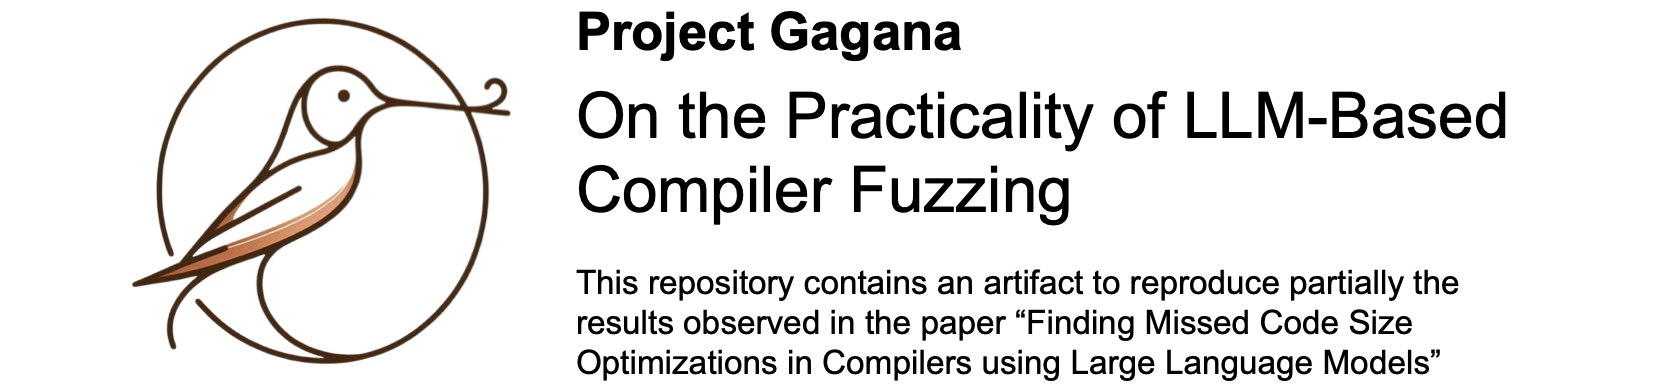

## Execution Instructions

1.  **GPU Configuration**:
    All models detailed in this document require a Graphics Processing Unit (GPU) for execution, with a minimum specification of a T4 GPU. For optimal alignment with the experimental results reported in the accompanying article, the use of an A100 GPU is highly recommended. To configure the GPU, navigate to the "Runtime Environment" (Ambiente de execução) settings, select "Change Runtime Type" (Alterar tipo de execução), and then choose the A100 GPU option. Please be aware that access to A100 GPUs typically necessitates a Google Colab Pro subscription.


*   Runtime Enviroment and  Change Runtime type

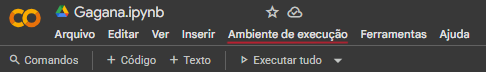

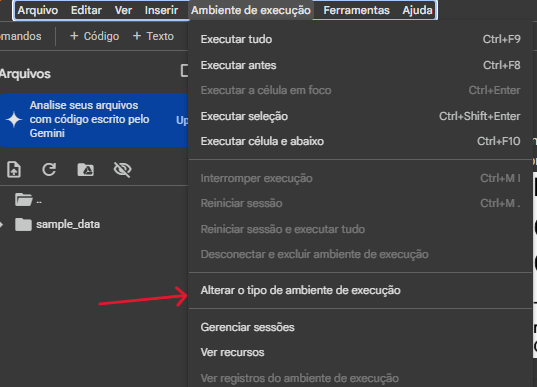

* A100 GPU

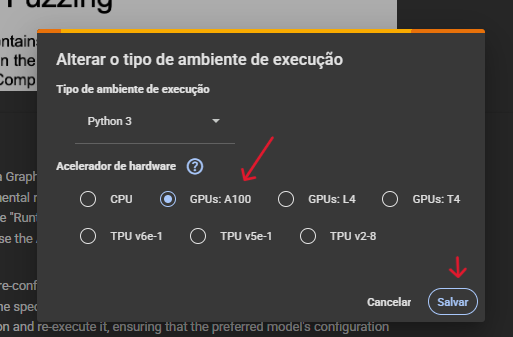


2.  **Cell Execution Sequence**:
    The provided computational cells are pre-configured to execute sequentially without manual intervention. However, within the "AI Config" section, it is essential to confirm the specific model designated for the current execution. Should a different model be desired, it may be necessary to reset the section and re-execute it, ensuring that the preferred model's configuration is uncommented. Futhermore, all the code used are presented in the class section and the generation section - which just run all the process.

    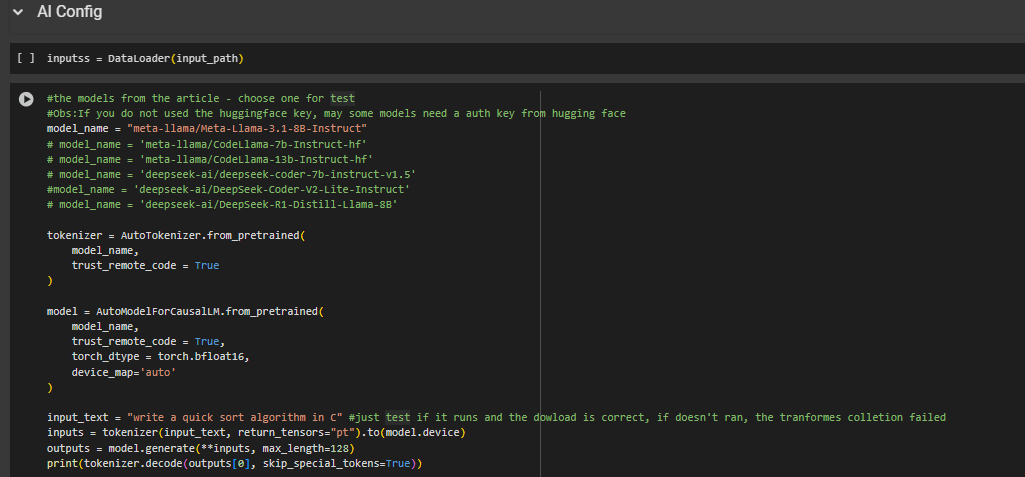

3.  **Accessing Results**:
    All generated outputs are stored within the Google Colab file system. These results are typically accessible via the left-hand navigation pane, by clicking the folder icon. A dedicated directory, labeled with the name of the selected model, will contain the output files. Programs generated via single-shot operations are located within the "single" subfolder. Conversely, the results of iterative mutation chains (representing distinct continuations derived from initial seed programs) are organized within the "chain" subfolder. Users are then advised to download these folder - the model folder - and proceed with the provided compilation scripts.

    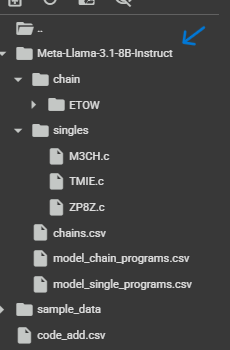

### Imports

In [ ]:
!pip install --upgrade transformers
!pip install transformers==4.46.0

In [2]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
) #the model

import torch #for the model

import numpy as np #to better use of the arrays

import time #measure time

import pandas as pd #for csv

import statsmodels.api as sm #for run stats
import seaborn as sns

from google.colab import drive #to import the csv and other data
from google.colab import auth
from google.colab import userdata

from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload
from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.http import MediaIoBaseUpload
import io  # necessário para usar io.BytesIO
from io import BytesIO

from huggingface_hub import login


import subprocess #for write file...
import random
import string
import os
import sys

In [ ]:
import pandas as pd
import os

# create the DataFrame with specific values for the input of the models
# used for make sure no need to create any archive
data = {
    'id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    'type': [
        'control_flow', 'control_flow', 'control_flow', 'control_flow',
        'control_flow', 'control_flow', 'control_flow', 'control_flow',
        'conditionals', 'conditionals', 'aggregates/pointers',
        'aggregates/pointers', 'aggregates/pointers', 'function_arguments'
    ],
    'value': [
        'add a conditional statement with a statement inside',
        'add a nested conditional statement with a non trivial condition and a statement inside',
        'add a dead conditional statement with a statement inside',
        'add a dead nested conditional statement with a non trivial condition and a statement inside',
        'add a loop with a complex condition and statement inside',
        'add a dead loop with a complex condition and statement inside',
        'add a nested loop with a complex condition and a statement inside',
        'add a dead nested loop with a complex condition and a statement inside',
        'make a condition more complicated',
        'make a dead condition more complicated',
        'add array code',
        'add pointers code',
        'add struct code usage',
        'add function arguments to a function thats already exists and no default arguments'
    ]
}
df_code_add = pd.DataFrame(data)


print("Inline DataFrame (created values):")
print(df_code_add.to_markdown(index=False, numalign="left", stralign="left"))

output_dir = "/content/"
os.makedirs(output_dir, exist_ok=True) # ensure the directory exists

output_path = os.path.join(output_dir, "code_add.csv")
df_code_add.to_csv(output_path, index=False)

print(f"\nDataFrame exported to: {output_path}")

In [4]:
parent_folder_name = '/content/' #is needed to define where the models folder gonna be, please don't change it
input_path = parent_folder_name+'code_add.csv' #inputs data for any generation

In [ ]:
login("") #hugging face key for models reading only

### Classes

####Local File Manager
This is a class for manage the files on drive content.

In [6]:
class LocalFileManager:

    @staticmethod
    def find_file(parent_folder_path: str, file_name: str):

        file_path = os.path.join(parent_folder_path, file_name)
        if os.path.exists(file_path) and os.path.isfile(file_path):
            return {'path': file_path, 'name': file_name} # return a dict with the path of the class and the name
        return None

    @staticmethod
    def find_file_recursive(parent_folder_path: str, filename: str):
        # search the file recursively, first on the parent, than the childs
        result = LocalFileManager.find_file(parent_folder_path, filename)
        if result:
            return result

        # iter in the dirs
        for root, dirs, files in os.walk(parent_folder_path):
            for dir_name in dirs:
                folder_path = os.path.join(root, dir_name)
                result = LocalFileManager.find_file(folder_path, filename)
                if result:
                    return result
        return None

    @staticmethod
    def upload_empty_csv(parent_folder_path: str, file_name: str): #create the csvs that suport the model generation
        headers = {
            'model_single_programs.csv': ['model_name','seconds','code_name','caracteristcs','length'],
            'model_chain_programs.csv': ['model_name', 'seconds', 'code_name', 'characteristics', 'length', 'previous_code', 'folder_id'],
            'chains.csv': ['folder_id', 'num_programs', 'time_spent', 'mean_time_program', 'compilation', 'model_name']
        }
        df = pd.DataFrame(columns=headers.get(file_name, []))
        file_path = os.path.join(parent_folder_path, file_name)

        os.makedirs(parent_folder_path, exist_ok=True) #make sure the dir exist

        try:
            df.to_csv(file_path, index=False)
        except Exception as e:
            print(f"Erro: {e}")

    @staticmethod
    def upload_and_get_file(parent_folder_path: str, local_source_path: str, upload_name: str):
        destination_path = os.path.join(parent_folder_path, upload_name)

        os.makedirs(parent_folder_path, exist_ok=True)

        try: #write the file
            with open(local_source_path, 'rb') as src, open(destination_path, 'wb') as dst:
                dst.write(src.read())
            return LocalFileManager.find_file(parent_folder_path, upload_name)
        except Exception as e:
            print(f"Erro: {e}")
            return None

    @staticmethod
    def upload_single_file_to_drive(folder_path: str, code_name: str, program: str):
        os.makedirs(folder_path, exist_ok=True)
        local_file_path = os.path.join(folder_path, f"{code_name}.c")
        # upload a single file in drive, this is used in single shot generation
        try:
            with open(local_file_path, "w", encoding='utf-8') as file:
                file.write(program)
        except Exception as e:
            print(f"ERRO: {e}")

    @staticmethod
    def upload_chain_file_to_drive(program: str, folder_path: str, folder_name: str, n: int):
        os.makedirs(folder_path, exist_ok=True)
        local_file_path = os.path.join(folder_path, f"{folder_name}{n}.c")
        # upload a single file from a specific chain, on iterative mutation
        try:
            with open(local_file_path, "w", encoding='utf-8') as file:
                file.write(program)
        except Exception as e:
            print(f"ERRO: {e}")

    @staticmethod
    def folder_generator(base_path: str, folder_data, size: int = 4):
        chars = string.ascii_uppercase
        while True:
            random_name = ''.join(random.choice(chars) for _ in range(size))
            # generate the folder for the iterative mutation on a new chain
            if random_name not in folder_data.column_values('folder_id'):
                break

        folder_path = os.path.join(base_path, random_name)
        try:
            os.makedirs(folder_path, exist_ok=True)
            return folder_path, random_name
        except Exception as e:
            raise RuntimeError(f"Runtime ERROR: {e}")

    @staticmethod
    def find_folder(parent_folder_path: str, folder_name: str):
        folder_path = os.path.join(parent_folder_path, folder_name)
        #in case of search in a specific code for ensure the generation
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            return folder_path, folder_name
        return None, None

    @staticmethod
    def create_folder_model(parent_folder_path: str, model_folder_name: str):
        main_folder_path = os.path.join(parent_folder_path, model_folder_name)
        chain_folder_path = os.path.join(main_folder_path, 'chain')
        singles_folder_path = os.path.join(main_folder_path, 'singles')
        #create the folder of the current model on the content for the drive
        try:
            os.makedirs(main_folder_path, exist_ok=True)
            os.makedirs(chain_folder_path, exist_ok=True)
            os.makedirs(singles_folder_path, exist_ok=True)
            return main_folder_path, model_folder_name, singles_folder_path, chain_folder_path
        except Exception as e:
            raise RuntimeError(f"ERRO: {e}")

#### DataLoader
A collection and encapsultation of functions to use the dataframe correctly, processing all the data needed in the generation.

In [7]:
class DataLoader:
    def __init__(
        self,
        file_path: str = None
    ):

        # Initialize DataLoader from a local path.

        self.file_path = file_path
        if file_path and os.path.exists(file_path):
            try:
                self.dataframe = pd.read_csv(file_path)
            except Exception as e:
                print(f"Erro on load {file_path}: {e}")
                sys.exit(-1)
        else:
            self.dataframe = pd.DataFrame()

    def save(self):
        #Save changes back to original source.
        self.dataframe.to_csv(self.file_path, index=False)

    def column_values(self,column_name):#Get a list of values in a column
        try:
            return self.dataframe[column_name].values
        except:
            raise Exception("Column must be wrong.")

    def new_row(self, new_values: list):#Matches two list to form a new data row
      if len(new_values) != len(self.dataframe.columns):
          raise ValueError("The number of values does not match the number of columns.")

      # Create a DataFrame from the new row values
      new_row = pd.DataFrame([dict(zip(self.dataframe.columns, new_values))])

      self.dataframe = pd.concat([self.dataframe, new_row], ignore_index=True)

    def update_row(self,index: str, new_values:list):
        if len(new_values) != len(self.dataframe.columns):
            raise ValueError("The number of values does not match the number of columns.")
        self.dataframe = self.dataframe.set_index(index)
        self.dataframe.loc[new_values[0]] = new_values[1:]
        self.dataframe = self.dataframe.reset_index()


    def get_row(self, column: str, key: any):#Get all row using a key
        row = self.dataframe.set_index(column).loc[[key]]  # [[key]] to ensure good research
        values = row.values.flatten().tolist()
        return values

    def static_row_string(self,id,ignore_columns=""):#from a give value return the data
        if(id==0):
            return "Impossible to pick the value."

        else:

            if not ignore_columns == "": #if there is a column...
                static = self.dataframe.drop(ignore_columns, axis=1).iloc[id]

            else:
                static = self.dataframe.iloc[id]

            static = static.to_string(index=False)
            return static

    def random_row_string(self, ignore_columns=""):#return a random row, used for random input
        random_row = self.dataframe.sample()
        id_value = random_row['id'].values[0]

        if ignore_columns:
            if isinstance(ignore_columns, str):
                ignore_columns = [ignore_columns]
            random_row = random_row.drop(ignore_columns, axis=1)

        random_row = random_row.drop('id', axis=1, errors='ignore')

        values = [str(val).replace('"', '').replace("'", '').strip()
                  for val in random_row.values[0]]
        result_string = ' '.join(values)

        return result_string.strip(), id_value




#### CodeGeneration
A TAD for the code generation process, it is essentially output generation and data registration.

In [8]:

class CodeGeneration:

    def __init__(self,model,model_name,tokenizer,data : DataLoader,input_str: str,input_id : int,
                 max_length : int, base_code: str,name_atr:str):
        self.model = model #the llm model
        self.model_name = model_name #the name, for registration only
        self.data = data #the  DataLoader of the programs
        self.input_str = input_str #the input
        self.max_length = max_length #max length of generation, set it to 2048 by default
        self.input_id = input_id #the id of the input
        self.tokenizer = tokenizer #tokenizer
        self.base_code = base_code #the current seed
        self.name_atr = name_atr #the attr of the name, for random name generation

        #the input of the model
        self.template = f"""
        Rewrite this code to {self.input_str}:
        {self.base_code}

        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            {self.base_code}
            </Program>
        """

        self.dif_seconds = 0 #time generation measurement
        self.ouput = "" #output
        self.program_name = "" #the random name of the program
        self.program = "" #the program that will be generated


    def generate_code(self):#Measure time and generate the code
        input_time = time.time()
        inputs = self.tokenizer(self.template, return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(**inputs, max_length=self.max_length) #model output
        output_time = time.time()

        self.dif_seconds = (output_time - input_time) #time measure
        decoded_output = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        self.output = decoded_output


    def get_output_list(self):#Return the data from the program generation

        if self.program.strip() == self.base_code.strip() or len(self.program) <= len(self.base_code) + 10:
            return [self.model_name, self.dif_seconds, self.program_name, self.input_id, -1]

        len_program = len(self.tokenizer.encode(self.program)) #Count the amount of tokens in the program
        return [self.model_name,
                self.dif_seconds,
                self.program_name,
                self.input_id,
                len_program]


    def program_extratcion(self):#return the program generated, just verifies if generate any program, do not verify correcteness of code
        self.name_generator()

        if self.program == "":
            final_program = ""
            suboutput_list = self.output.split("<Program>")#Extract from the tags

            for subprogram in (suboutput_list):
              if "</Program>" in subprogram:
                program = subprogram.split("</Program>")[0]

                if program.count('{') == program.count('}'):
                        final_program = program

            self.program = final_program

        return self.program


    def name_generator(self,size=4): #Randomly generate a new file name

        if self.program_name == "" :
            chars=string.ascii_uppercase + string.digits
            random_name = ''.join(random.choice(chars) for _ in range(size))
            while random_name in self.data.column_values(self.name_atr):
                random_name = ''.join(random.choice(chars) for _ in range(size))
            self.program_name = random_name




#### Generation Pipeline
The pipeline of the sampling processes. Control the execution flow and achieve the single-shot aproach or iterative mutation, using the methods of sampling for each case.

In [9]:

class GenerationPipeline:
    def __init__(
            self,
            model: object,
            model_name: str,
            tokenizer: object,
            input_data_path: str,
            parent_path: str,
            model_name_folder: str,
        ):
        self.model = model #the llm model
        self.model_name = model_name
        self.tokenizer = tokenizer
        self.input_data = DataLoader(input_data_path)  #the input dataframe

        self.ignore_columns = ['id', 'type']

        try: #create the folder of the current model, for clean and auto generation
            folder_path, folder_name= LocalFileManager.find_folder(parent_path, model_name_folder)

            if folder_path is None:
                folder_path, folder_name,single_folder_path,chain_folder_path = LocalFileManager.create_folder_model(parent_path, model_name_folder)
            else:
              single_folder_path, _ = LocalFileManager.find_folder(folder_path, 'singles')
              chain_folder_path, _ = LocalFileManager.find_folder(folder_path, 'chain')

            self.folder_path = folder_path
            self.single_folder_path = single_folder_path
            self.chain_folder_path = chain_folder_path
            #the data for every generation case, create by default the empty csv if does not exist
            csv_names = ['model_single_programs.csv', 'model_chain_programs.csv', 'chains.csv']
            loaders = []
            for name in csv_names:
                file = LocalFileManager.find_file(self.folder_path, name)
                if file is None:
                    LocalFileManager.upload_empty_csv(self.folder_path, name)
                    file = LocalFileManager.find_file(self.folder_path, name)
                loaders.append(DataLoader(file['path']))


            #single-shot programs, iterative mutation programs and iterative-mutation chains (the programs seqeuence for i.m)
            self.models_data, self.models_chain, self.chains_data = loaders
            print(self.models_chain.column_values('folder_id'))

        except Exception as e:
            raise RuntimeError(f"ERRO on Pipeline creation: {e}")

    def single_code_generation(self, max_len: int, static: bool = False, id: int = 0):
        try:#run the single-shot code generation
            if static:
                input_value, input_id = self.input_data.static_row_string(id, self.ignore_columns)
            else:
                input_value, input_id = self.input_data.random_row_string(self.ignore_columns)#the random input

            base_code = """ int f(int a) {
                return 0;
                }"""

            generator = CodeGeneration(
                model=self.model,
                model_name=self.model_name,
                tokenizer=self.tokenizer,
                data=self.models_data,
                input_str=input_value,
                input_id=input_id,
                max_length=max_len,
                base_code=base_code,
                name_atr='code_name'
            )

            generator.generate_code()#generate
            program = generator.program_extratcion()
            output_list = generator.get_output_list()

            if output_list[4] > 0:#if actually generate a program
                LocalFileManager.upload_single_file_to_drive(self.single_folder_path, output_list[2], program)

            self.models_data.new_row(output_list)#updates the data
            self.models_data.save()
            print("Program Generated!")
        except Exception as e:
            print(f"ERRO: {e}")

    def single_sampling(self, duration_hours=3):#single-shot test for any model
        current_max_length = 2048
        duration_seconds = duration_hours * 3600
        start_time = time.time()
        while (time.time() - start_time) < duration_seconds:#samples for 3 hours
            try:
                self.single_code_generation(current_max_length)
            except Exception as e:
                print(f"Critical Error: {e}")
        print(f"Sampling Done! Total samples: {duration_hours} hours")

    def chain_code_generation(self, max_len: int, n: int = 1):#a sequence for iterative mutation, aka chain
        try:#run the code generation
            ac_time = 0
            base_code = """ int f(int a) {
                    return 0;
                    }"""
            i = 0#first chain program is 0
            last_code_id = ''
            folder_path, folder_name = LocalFileManager.folder_generator(self.chain_folder_path, self.chains_data) #generate the chain folder
            rows_chain = [folder_name, i, ac_time, ac_time/n, "False", self.model_name]#create the chain in the csv of chains, important constraint for unique names
            self.chains_data.new_row(rows_chain)
            self.chains_data.save()
            for _ in range(n):
                input_value, input_id = self.input_data.random_row_string(self.ignore_columns)# current random input
                generator = CodeGeneration(
                    model=self.model,
                    model_name=self.model_name,
                    tokenizer=self.tokenizer,
                    data=self.models_chain,
                    input_str=input_value,
                    input_id=input_id,
                    max_length=max_len,
                    base_code=base_code,
                    name_atr='folder_id'
                )
                generator.generate_code()
                program = generator.program_extratcion()
                output_list = generator.get_output_list()

                ac_time = ac_time + output_list[1] #time even if the program was not generated

                if output_list[4] > 0:#if actually generate a program
                    last_code_id = 'None' if i == 0 else f'{folder_name}{i}'
                    i += 1
                    output_list.extend([last_code_id, folder_name])
                    output_list[2] = f'{folder_name}{i}'#the file name following the folder
                    self.models_chain.new_row(output_list)# updates the data
                    self.models_chain.save()
                    LocalFileManager.upload_chain_file_to_drive(program, folder_path, folder_name, i)#upload file
                    base_code = program
                    print("Another program generated!\n")

                rows_chain = [folder_name, i, ac_time, ac_time/n, "False", self.model_name]
                self.chains_data.update_row("folder_id", rows_chain)#update the programs data
                self.chains_data.save()

        except Exception as e:
            print(f"ERRO: {e}")

    def iterative_mutation_sampling(self, duration_hours=3):#iterative mutation test for a model
        current_max_length = 2048
        iterations = 30 #by default, we set the generation for max of 30 consecutive mutations
        duration_seconds = duration_hours * 3600
        start_time = time.time()
        while (time.time() - start_time) < duration_seconds:#sampling for 3 hours
            try:
                self.chain_code_generation(current_max_length, iterations)
            except Exception as e:
                print(f"Critical Error: {e}")
        print(f"Sampling Done! Total samples: {duration_hours} hours")

### AI Config

In [10]:
inputss = DataLoader(input_path)

In [ ]:
#the models from the article - choose one for test
#Obs:If you do not used the huggingface key, may some models need a auth key from hugging face
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
# model_name = 'meta-llama/CodeLlama-7b-Instruct-hf'
# model_name = 'meta-llama/CodeLlama-13b-Instruct-hf'
# model_name = 'deepseek-ai/deepseek-coder-7b-instruct-v1.5'
#model_name = 'deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct'
# model_name = 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B'

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code = True
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code = True,
    torch_dtype = torch.bfloat16,
    device_map='auto'
)

input_text = "write a quick sort algorithm in C" #just test if it runs and the dowload is correct, if doesn't ran, the tranformes colletion failed
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_length=128)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

### Generation (Single-Shot and Iterative Mutation Run Process)

In [ ]:
#for single-shot aproach - sometimes drive update in file update too slow, so try again if the error is read the csv
pipeline = GenerationPipeline(model, model_name, tokenizer,input_path,parent_folder_name,model_name.split('/')[1])
pipeline = pipeline.single_sampling(duration_hours=3)

In [ ]:
pipeline = GenerationPipeline(model, model_name, tokenizer,input_path,parent_folder_name,model_name.split('/')[1]) #for iterative aproach
pipeline = pipeline.iterative_mutation_sampling(duration_hours=3)